In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# داده را از فایل اکسل می‌خوانیم
# Load data from Excel file
df = pd.read_excel('/content/sample-orders.xlsx')

In [4]:
# حذف فاصله‌ی اضافی از نام ستون‌ها
# Remove extra spaces from column names
df.columns = df.columns.str.strip()

# تبدیل ستون تاریخ سفارش به نوع داده datetime
# Convert 'order_date' column to datetime
df['order_date'] = pd.to_datetime(df['order_date'])


In [5]:
# تعیین مرجع زمانی: یک روز بعد از بیشترین تاریخ سفارش برای محاسبه Recency
# Set reference date: one day after the maximum order date to calculate Recency
reference_date = df['order_date'].max() + pd.Timedelta(days=1)

# محاسبه RFM برای هر مشتری
# Calculate RFM metrics for each customer
rfm = df.groupby('customer').agg({
    'order_date': lambda x: (reference_date - x.max()).days,    # Recency
    'order_id': 'count',                                      # Frequency
    "grand_total": 'sum'                                         # Monetary
}).reset_index()
rfm.columns = ['customer', 'Recency', 'Frequency', 'Monetary']

# محاسبه کوانتایلهای Recency و Frequency
# Calculate quantile cutoffs (33%, 66%) for Recency and Frequency
recency_quartile = rfm['Recency'].quantile([0.33, 0.66]).values
frequency_quartile = rfm['Frequency'].quantile([0.33, 0.66]).values


In [6]:

# تابع برای اختصاص خوشه براساس مقادیر Recency و Frequency
# Function to assign a cluster based on Recency and Frequency values
def assign_cluster(row):
    # مشتری جدید: Recency کم (در یک‌سوم کمترین Recency)
    # New customer: low Recency (lowest third)
    if row['Recency'] <= recency_quartile[0]:
        return 'New'
    # مشتری کم‌فعالیت: Recency بالا (یک‌سوم بالا) یا Frequency پایین (یک‌سوم پایین)
    # Inactive customer: high Recency (highest third) or low Frequency (lowest third)
    elif row['Recency'] > recency_quartile[1] or row['Frequency'] <= frequency_quartile[0]:
        return 'Inactive'
    # مشتری ثابت: سایرین
    # Fixed/Active customer: others
    else:
        return 'Fixed'

# اختصاص نام خوشه به هر مشتری
# Assign cluster name to each customer
rfm['Cluster'] = rfm.apply(assign_cluster, axis=1)

# نمایش نمونه‌ای از جدول خروجی
# Print a sample of the output table
print(rfm[['customer', 'Recency', 'Frequency', 'Monetary', 'Cluster']].head(10).to_markdown(index=False))

| customer           |   Recency |   Frequency |   Monetary | Cluster   |
|:-------------------|----------:|------------:|-----------:|:----------|
| Aaron Bergman      |        32 |           3 |        887 | New       |
| Aaron Hawkins      |      3649 |           7 |       1744 | Inactive  |
| Aaron Smayling     |       581 |           7 |       3050 | Fixed     |
| Adam Bellavance    |       154 |           8 |       7756 | New       |
| Adam Hart          |      3671 |          10 |       3249 | Inactive  |
| Adam Shillingsburg |        94 |           9 |       3256 | New       |
| Adrian Barton      |       156 |          10 |      14474 | New       |
| Adrian Hane        |       336 |           7 |       1734 | Fixed     |
| Adrian Shami       |      3678 |           2 |         59 | Inactive  |
| Aimee Bixby        |       430 |           5 |        968 | Inactive  |


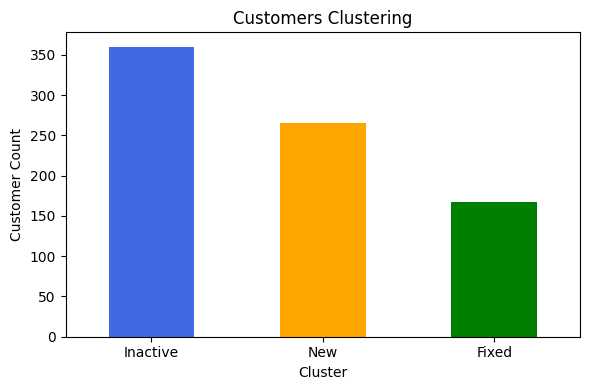

In [7]:
# رسم نمودار ستونی برای نمایش تعداد مشتری در هر خوشه
# Plot bar chart for number of customers in each cluster
plt.figure(figsize=(6,4))
rfm['Cluster'].value_counts().plot(kind='bar', color=['royalblue','orange','green'])
plt.title('Customers Clustering')
plt.ylabel('Customer Count')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()